<a href="https://colab.research.google.com/github/MateoPeri/steel-scrap-predictor/blob/master/Steel%20Scrap%20Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import glob, os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
import matplotlib.pyplot as plt
import altair as alt
plt.style.use('seaborn-poster')

# Data preparation

In [0]:
!rm -rf '/content/data'
!mkdir data
PATH = '/content/data/'
!wget -P {PATH} https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
!unzip {PATH}raw.zip -d {PATH}

--2020-06-08 10:42:53--  https://raw.githubusercontent.com/MateoPeri/steel-scrap-predictor/master/data/raw.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244524 (239K) [application/zip]
Saving to: ‘/content/data/raw.zip’

raw.zip             100%[===================>] 238.79K  --.-KB/s    in 0.05s   

2020-06-08 10:42:53 (4.41 MB/s) - ‘/content/data/raw.zip’ saved [244524/244524]

Archive:  /content/data/raw.zip
   creating: /content/data/raw/
  inflating: /content/data/raw/SC Final Settlement prices.xlsx  
  inflating: /content/data/__MACOSX/raw/._SC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HC Final Settlement prices.xlsx  
  inflating: /content/data/__MACOSX/raw/._HC Final Settlement prices.xlsx  
  inflating: /content/data/raw/HC Clos

## Load dataset

In [0]:
def st_to_mt(st):
  return st/1.10231131

In [0]:
p = PATH+'raw/*Closing Prices.xlsx'
excels = glob.glob(p)

frames = []
to_keep = 'M1'

for xcel in excels:
  df = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if name == 'HU':
    # Seleccionar todas las columnas menos USD/st
    cols = [c for c in df.columns if c != 'USD/st (Short Ton)']
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    df[cols] = df[cols].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    df.rename({'USD/st (Short Ton)': 'USD/mt'}, axis=1, inplace=True)
  
  df.rename({'USD/mt': 'Date', to_keep: name}, axis=1, inplace=True)
  df = df[['Date', name]]
  
  frames.append(df)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()

SR Closing Prices.xlsx
SC Closing Prices.xlsx
HU Closing Prices.xlsx
HC Closing Prices.xlsx


,SR,SC,HU,HC
Date,,,,
2015-11-23,338.0,195.0,NaN,NaN
2015-11-24,337.0,195.0,NaN,NaN
2015-11-25,335.0,195.0,NaN,NaN
2015-11-26,334.0,192.0,NaN,NaN
2015-11-27,334.0,192.0,NaN,NaN


In [0]:
# Cuando empiezan los valores de HU y HC -> 2019-03-11
df = df.loc[df.HU.notna() | df.HC.notna()]
df.head()

,SR,SC,HU,HC
Date,,,,
2019-03-11,478.0,327.0,638.204465,525.0
2019-03-12,481.0,327.0,638.204465,526.0
2019-03-13,481.0,327.0,636.843688,528.0
2019-03-14,481.0,327.0,635.029319,531.0
2019-03-15,476.0,326.5,637.750873,533.0


In [0]:
# Contamos los valores nulos del dataset -> 0
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2019-03-11 to 2020-05-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR      292 non-null    float64
 1   SC      292 non-null    float64
 2   HU      292 non-null    float64
 3   HC      292 non-null    float64
dtypes: float64(4)
memory usage: 11.4 KB


# Data visualization

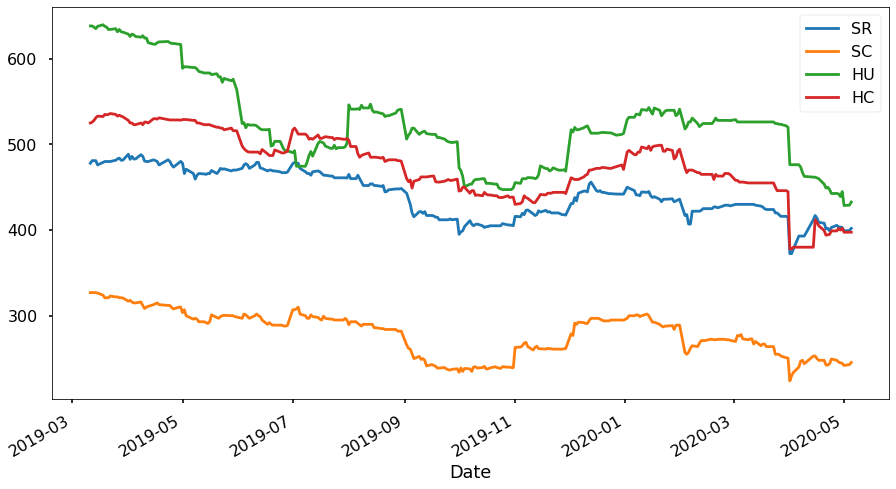

In [0]:
df.plot(figsize=(15,8))

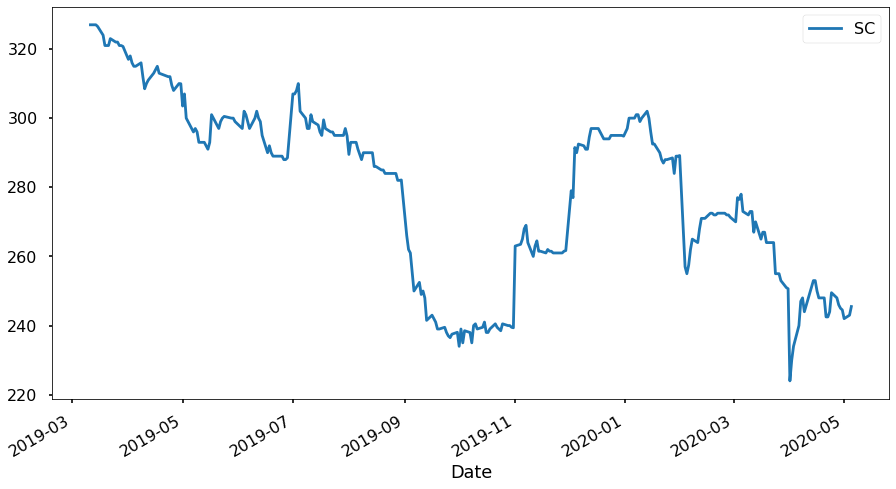

In [0]:
df[['SC']].plot(figsize=(15,8))

# Model

In [0]:
to_predict = 'SC'
data = df.reset_index().copy()

In [0]:
def add_caps(d, c='y'):
  d['cap'] = d[c].max()
  d['floor'] = d[c].min()
  return d

In [0]:
def generate_model(dff):
  fecha = '2019-03-11'

  others = dff[[c for c in df.columns if c not in ['Date', to_predict]]]
  dff.rename({'Date': 'ds', to_predict: 'y'}, axis=1, inplace=True)
  #dff = dff[['ds', 'y']]

  dff = dff.loc[dff.ds > fecha].copy()
  dff = add_caps(dff)
  modelo_futuro = Prophet(growth='linear', seasonality_mode='additive', yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
  for o in others:
    modelo_futuro.add_regressor(o)

  return modelo_futuro, dff

In [0]:
model, df_pred = generate_model(data)
df_pred.head()

,ds,SR,y,HU,HC,cap,floor
1,2019-03-12,481.0,327.0,638.204465,526.0,327.0,224.0
2,2019-03-13,481.0,327.0,636.843688,528.0,327.0,224.0
3,2019-03-14,481.0,327.0,635.029319,531.0,327.0,224.0
4,2019-03-15,476.0,326.5,637.750873,533.0,327.0,224.0
5,2019-03-18,479.0,324.0,639.565242,532.5,327.0,224.0


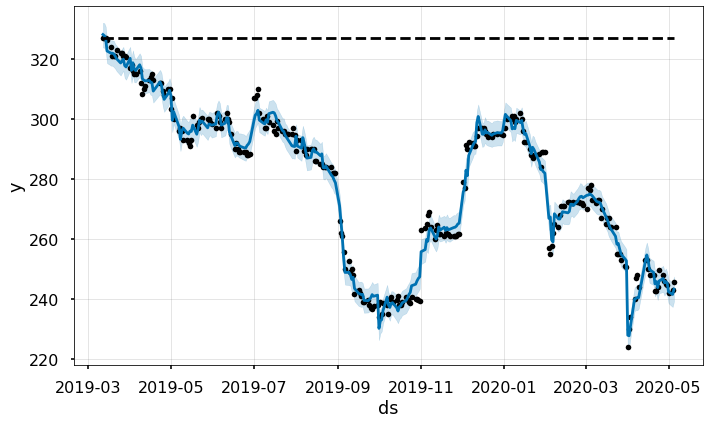

In [0]:
model.fit(df_pred)
forecast = model.predict(df_pred)
fig = model.plot(forecast)

In [0]:
forecast['fact'] = df_pred['y'].reset_index(drop = True)
print('Accuracy: {:.2f}%'.format(r2_score(forecast.fact, forecast.yhat)*100))

Accuracy: 98.44%


# Predict Future [EN PROCESO]

In [0]:
# 3 more months from end of data
future = model.make_future_dataframe(periods=90, freq='d')
future = add_caps(df_pred)

In [0]:
p = PATH+'raw/*Settlement prices.xlsx'
excels = glob.glob(p)

frames = []

for xcel in excels:
  df = pd.read_excel(xcel, parse_dates=True, decimal=',', thousands='.')
  # le añadimos un nombre para saber qué metal es
  name = os.path.basename(xcel)[:2]
  if (name == 'HU'):
    # y aplicarles la funcion st_to_mt para pasar a toneladas métricas
    df[['USD/st']] = df[['USD/st']].apply(st_to_mt, axis=1)
    # Cambiamos el nombre a la columna
    df.rename({'USD/st': 'USD/mt'}, axis=1, inplace=True)
  
  df.rename({'USD/mt': name, 'Currency/unit': 'Date'}, axis=1, inplace=True)
  df = df[['Date', name]]
  
  frames.append(df)

dfs = [d.drop_duplicates().set_index(['Date']) for d in frames]
df = pd.concat(dfs, axis=1)

df.head()

,HC,HU,SR,SC
Date,,,,
2015-11-01,NaN,NaN,341.33,195.52
2015-12-01,NaN,NaN,326.31,188.95
2016-01-01,NaN,NaN,323.18,185.75
2016-02-01,NaN,NaN,318.81,177.05
2016-03-01,NaN,NaN,363.00,216.19


In [0]:
future_forecast = model.predict(future)
fig = model.plot(future_forecast)